# News Headline Classification:
# Comparison of Traditional ML and Transformer Models

---


# Baseline Models: Traditional ML models

In [ ]:
#STEP1
from google.colab import drive
drive.mount('/content/drive')

import os, json
BASE_DIR = "/content/drive/MyDrive/news-headline-cat"
os.makedirs(f"{BASE_DIR}/notebooks", exist_ok=True)
os.makedirs(f"{BASE_DIR}/reports/figs", exist_ok=True)
os.makedirs(f"{BASE_DIR}/reports/tables", exist_ok=True)
os.makedirs(f"{BASE_DIR}/models", exist_ok=True)
print("BASE_DIR =", BASE_DIR)

In [ ]:
!pip install -q datasets scikit-learn evaluate matplotlib seaborn joblib


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
#STEP3
from datasets import load_dataset

# Load AG News (auto-downloads & caches in Drive)
raw = load_dataset("ag_news")  # train ~120k, test ~7.6k

# Hold out 10% of train for dev using a fixed seed (and stratify by label)
split = raw["train"].train_test_split(test_size=0.10, seed=42, stratify_by_column="label")
train_ds, dev_ds = split["train"], split["test"]
test_ds = raw["test"]

label_names = ["World", "Sports", "Business", "Sci/Tech"]
print("Sizes → train:", len(train_ds), "dev:", len(dev_ds), "test:", len(test_ds))
print("Sample →", train_ds[0]["text"], "→", label_names[train_ds[0]["label"]])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Sizes → train: 108000 dev: 12000 test: 7600
Sample → Three tied for lead at Southern Farm Bureau Classic John Senden carded a pair of eagles, Harrison Frazar shot a 31 on the front nine and Glen Day recorded seven birdies to finish Thursday #39;s first round of the  → Sports


## Dataset

**AG News** (Hugging Face ID: `ag_news`). It’s a well-established benchmark for topic classification of *short news headlines* with four labels:

* `0 = World`
* `1 = Sports`
* `2 = Business`
* `3 = Sci/Tech`


* **Train:** ~120,000 items
* **Test:** ~7,600 items


In [ ]:
#STEP4
from sklearn.feature_extraction.text import TfidfVectorizer

# 1) Gather texts/labels
X_train_text = [r["text"] for r in train_ds]
y_train      = [r["label"] for r in train_ds]
X_dev_text   = [r["text"] for r in dev_ds]
y_dev        = [r["label"] for r in dev_ds]

# 2) Vectorizer config: uni+bi-grams, cap features for speed/memory
tfidf = TfidfVectorizer(
    lowercase=True,
    ngram_range=(1, 2),
    max_features=50000,
    sublinear_tf=True # 1 + log tf instead of just tf values
)

# 3) Fit on train, transform train/dev
Xtr = tfidf.fit_transform(X_train_text)
Xdv = tfidf.transform(X_dev_text)

Xtr.shape, Xdv.shape


((108000, 50000), (12000, 50000))

# Step 4 — TF-IDF Feature Building

1. **Collected text and labels** from our **train** and **dev** splits created in Step 3.

2. **Configured a TF-IDF vectorizer** to build features:
-Normalization Done!

3. **Fit on train, transform both splits**

4. **Saved the fitted vectorizer** to Drive for reuse later


In [ ]:
#STEP5
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

Cs = [0.5, 1.0, 2.0, 4.0]
best = {"C": None, "macro_f1": -1.0, "model": None}

for C in Cs:
    clf = LogisticRegression(max_iter=300, n_jobs=-1, C=C)
    clf.fit(Xtr, y_train) #train model
    pred_dev = clf.predict(Xdv) #predict the labels

    mf1 = f1_score(y_dev, pred_dev, average="macro")
    print(f"C={C:.2f} → dev Macro-F1={mf1:.4f}")
    if mf1 > best["macro_f1"]:
        best = {"C": C, "macro_f1": mf1, "model": clf}

logreg = best["model"]   # keep the best model for later steps
print("Best LogReg:", best)


C=0.50 → dev Macro-F1=0.9174
C=1.00 → dev Macro-F1=0.9191
C=2.00 → dev Macro-F1=0.9196
C=4.00 → dev Macro-F1=0.9198
Best LogReg: {'C': 4.0, 'macro_f1': 0.9197532127395516, 'model': LogisticRegression(C=4.0, max_iter=300, n_jobs=-1)}


# Step 5 — Logistic Regression Baseline

## What did we observe?

* Dev Macro-F1 improved slightly as `C` increased: **0.917 → 0.920 (approx.)**, then **plateaued**.
* Best setting: **`C = 4.0`**, dev **Macro-F1 ≈ 0.9198** (≈0.920).

## Why Macro-F1?

* **Macro-F1** averages F1 across **all four classes** equally.
* It prevents a model from looking “good” by over-favoring easy or slightly more frequent classes, giving us a fairer signal for topic balance.


In [ ]:
#STEP6
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score

Cs = [0.5, 1.0, 2.0]
svm_best = {"C": None, "macro_f1": -1.0, "model": None}

for C in Cs:
    svm = LinearSVC(C=C)
    svm.fit(Xtr, y_train) #train
    pred_dev = svm.predict(Xdv) #predict
    mf1 = f1_score(y_dev, pred_dev, average="macro")
    print(f"SVM C={C:.2f} → dev Macro-F1={mf1:.4f}")
    if mf1 > svm_best["macro_f1"]:
        svm_best = {"C": C, "macro_f1": mf1, "model": svm} #same as logreg

# Choose the stronger performer between SVM and your best LogReg from Step 5
use_svm     = svm_best["macro_f1"] > best["macro_f1"]
final_model = svm_best["model"] if use_svm else logreg
final_name  = f"LinearSVC_C{svm_best['C']}" if use_svm else f"LogReg_C{best['C']}"
print("Using:", final_name, "| dev Macro-F1:",
      svm_best["macro_f1"] if use_svm else best["macro_f1"])


SVM C=0.50 → dev Macro-F1=0.9220
SVM C=1.00 → dev Macro-F1=0.9190
SVM C=2.00 → dev Macro-F1=0.9153
Using: LinearSVC_C0.5 | dev Macro-F1: 0.9220462748638544


# Step 6 — Linear SVM Baseline

1. **Kept the same TF-IDF features** from Step 4 (fit on train; transform train/dev).
2. **Swept the regularization strength `C`** over `{0.5, 1.0, 2.0}` on the **dev set**, selecting the model with the **highest Macro-F1**.
3. **Result (your run):**

   * `C=0.50 → Macro-F1 ≈ 0.9220`
   * `C=1.00 → Macro-F1 ≈ 0.9190`
   * `C=2.00 → Macro-F1 ≈ 0.9153`
     **Winner:** `LinearSVC (C=0.5)` with **dev Macro-F1 ≈ 0.9220**
4. **Compared to Logistic Regression (Step 5):** SVM slightly outperformed LogReg (≈0.9198), so SVM becomes our **final classic baseline**.


              precision    recall  f1-score   support

       World      0.937     0.912     0.925      3000
      Sports      0.962     0.982     0.972      3000
    Business      0.902     0.882     0.892      3000
    Sci/Tech      0.887     0.912     0.900      3000

    accuracy                          0.922     12000
   macro avg      0.922     0.922     0.922     12000
weighted avg      0.922     0.922     0.922     12000



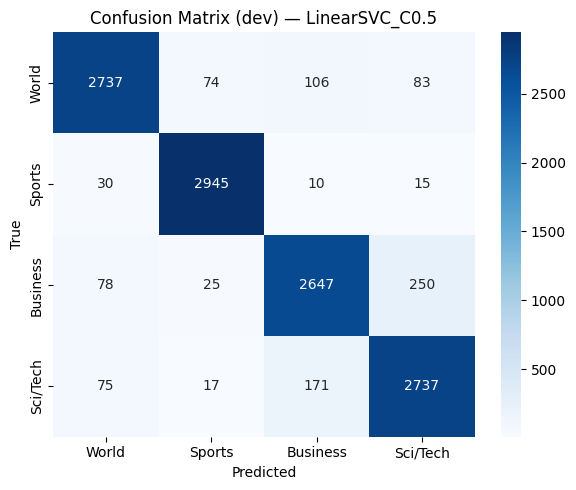

Saved: /content/drive/MyDrive/news-headline-cat/reports/figs/cm_dev_LinearSVC_C0.5.png and metrics JSON to reports/tables/, model to models/.


In [ ]:
#STEP 7

import seaborn as sns, matplotlib.pyplot as plt, json
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from joblib import dump

label_names = ["World", "Sports", "Business", "Sci/Tech"]

# Use the best classic model you selected in Step 6 - SVM!
final_model = svm_best["model"]            #SVM IS CHOSEN
final_name  = f"LinearSVC_C{svm_best['C']}"  #To tag all outputs.

# Dev predictions
pred_dev = final_model.predict(Xdv)

# Text report (per-class P/R/F1 + macro)
print(classification_report(y_dev, pred_dev, target_names=label_names, digits=3))

# Confusion matrix (dev)
cm = confusion_matrix(y_dev, pred_dev)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
plt.title(f"Confusion Matrix (dev) — {final_name}")
plt.xlabel("Predicted"); plt.ylabel("True")
fig_path = f"{BASE_DIR}/reports/figs/cm_dev_{final_name}.png"
plt.tight_layout(); plt.savefig(fig_path, dpi=150); plt.show()

# Save model
dump(final_model, f"{BASE_DIR}/models/{final_name}.joblib")

# Save metrics JSON
prec, rec, f1, _ = precision_recall_fscore_support(y_dev, pred_dev, average=None, labels=[0,1,2,3])
metrics = {
    "model": final_name,
    "macro_f1": float(sum(f1)/len(f1)),
    "accuracy": float(accuracy_score(y_dev, pred_dev)),
    "per_class": [
        {"label": label_names[i], "precision": float(prec[i]), "recall": float(rec[i]), "f1": float(f1[i])}
        for i in range(4)
    ],
    "confusion_matrix_path": fig_path
}
with open(f"{BASE_DIR}/reports/tables/dev_metrics_{final_name}.json","w") as f:
    json.dump(metrics, f, indent=2)

print("Saved:", fig_path, "and metrics JSON to reports/tables/, model to models/.")


In [ ]:
#STEP7.1 - ROBUSTNESS PROBE

import random, string
from sklearn.metrics import f1_score

def add_typos(text, rate=0.05):
    chars = list(text)
    for i, c in enumerate(chars):
        if c.isalpha() and random.random() < rate:
            chars[i] = random.choice(string.ascii_lowercase)
    return "".join(chars)

# Create noisy dev texts and transform with the SAME vectorizer
X_dev_text_noisy = [add_typos(t, rate=0.05) for t in X_dev_text]
Xdv_noisy = tfidf.transform(X_dev_text_noisy)

pred_noisy = final_model.predict(Xdv_noisy)

#compare models.
macro_f1_clean = f1_score(y_dev, pred_dev, average="macro")
macro_f1_noisy = f1_score(y_dev, pred_noisy, average="macro")
delta = macro_f1_clean - macro_f1_noisy

print(f"Macro-F1 clean: {macro_f1_clean:.4f} | noisy: {macro_f1_noisy:.4f} | Δ = {delta:.4f}")

with open(f"{BASE_DIR}/reports/tables/dev_robustness_{final_name}.json","w") as f:
    json.dump({"macro_f1_clean": float(macro_f1_clean),
               "macro_f1_noisy": float(macro_f1_noisy),
               "delta": float(delta)}, f, indent=2)


Macro-F1 clean: 0.9220 | noisy: 0.9098 | Δ = 0.0122


# Step 7 — Dev Evaluation, Confusion Matrix, and Robustness

## Summary of results

* **Accuracy:** **0.922**
* **Macro-F1 (clean):** **0.922**
* **Per-class (P / R / F1):**

  * **World:** 0.937 / 0.912 / **0.925**
  * **Sports:** 0.962 / 0.982 / **0.972**
  * **Business:** 0.902 / 0.882 / **0.892**
  * **Sci/Tech:** 0.887 / 0.912 / **0.900**

**Overall verdict:** This is a **strong TF-IDF baseline**. Sports is easiest; World solid; **Business** and **Sci/Tech** are the challenging pair.


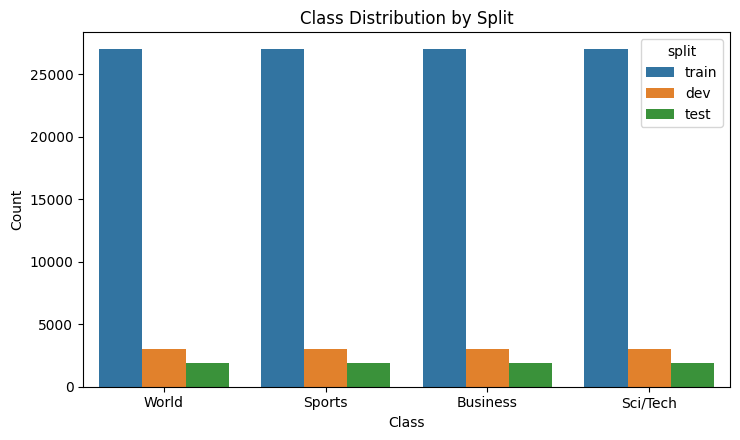

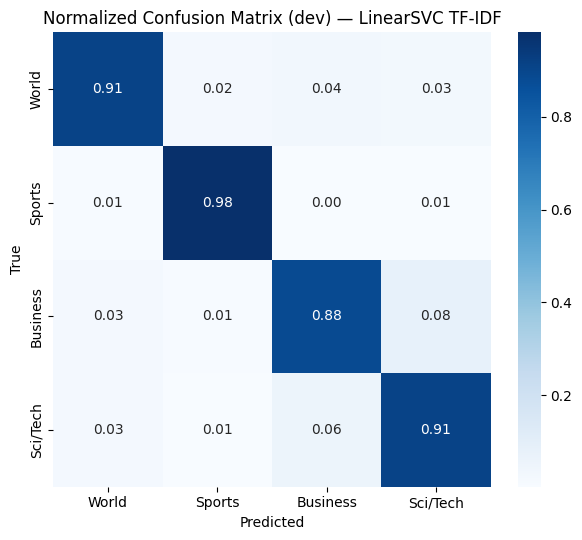

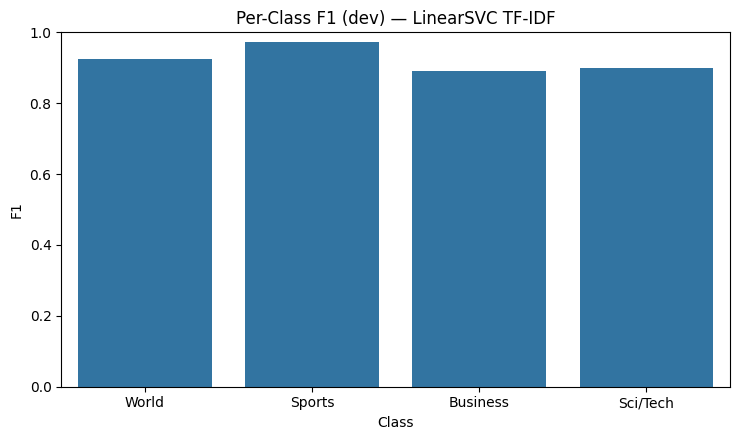

Top n-grams per class (first few rows):


,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8
World,canadian press,afp afp,york stocks,athens greece,iraq,nuclear,afp,iraqi
Sports,coach,sports,cup,nba,nascar,team,stadium,league
Business,hellip,economy,tax,oil,retailers,airlines,martha,bank
Sci/Tech,nasa,space,apple,linux,internet,software,scientists,science


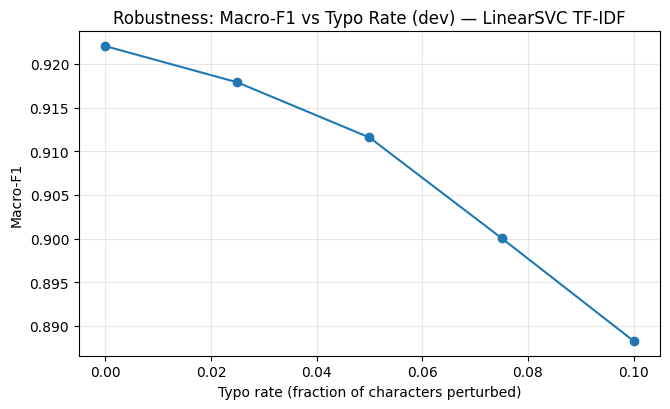

,headline,true,pred
0,"Bangalore Thrives, Chokes on Outsourcing BANG...",Business,World
1,Jury Selection Begins in Kobe Bryant Case EAGL...,World,Sports
2,"WTO rules against EU sugar subsidies, bloc to ...",World,Business
3,Scientists work to protect crops SUFFOLK -- Vi...,Business,Sci/Tech
4,"Infineon Revs Up, But Slowdown Coming Memory w...",Business,Sci/Tech
5,Consumer Prices Climb; Jobless Claims Up WASHI...,World,Business
6,"QRS Spurns JDA, Chooses Inovis QRS received fi...",Business,Sci/Tech
7,Moving music off your PC? New gadgets abound A...,Business,Sci/Tech
8,Tendulkar equals world record for test centuri...,World,Sports
9,Effort Intensifies to Secure Penn Station (AP)...,World,Sci/Tech



Saved figures:
 - /content/drive/MyDrive/news-headline-cat/reports/figs/class_distribution.png
 - /content/drive/MyDrive/news-headline-cat/reports/figs/cm_dev_normalized_LinearSVC.png
 - /content/drive/MyDrive/news-headline-cat/reports/figs/per_class_f1_dev_LinearSVC.png
 - /content/drive/MyDrive/news-headline-cat/reports/figs/robustness_curve_dev_LinearSVC.png

Saved tables:
 - /content/drive/MyDrive/news-headline-cat/reports/tables/per_class_dev_metrics_LinearSVC.csv
 - /content/drive/MyDrive/news-headline-cat/reports/tables/top_ngrams_per_class_LinearSVC.csv
 - /content/drive/MyDrive/news-headline-cat/reports/tables/robustness_sweep_dev_LinearSVC.csv
 - /content/drive/MyDrive/news-headline-cat/reports/tables/dev_sample_errors_LinearSVC.csv


In [ ]:
#STEP8 === BASELINE VISUALS & INSIGHTS
import os, json, random, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_recall_fscore_support, accuracy_score, f1_score
)

# Assumptions from previous steps
# BASE_DIR, train_ds, dev_ds, test_ds
# tfidf, final_model (LinearSVC), label_names = ["World","Sports","Business","Sci/Tech"]
# Xdv, y_dev, X_dev_text  (from TF-IDF step)
# pred_dev (optional) – recompute if missing

os.makedirs(f"{BASE_DIR}/reports/figs", exist_ok=True)
os.makedirs(f"{BASE_DIR}/reports/tables", exist_ok=True)

# Helper: map label ids<->names
id2name = {i: n for i, n in enumerate(label_names)}
name2id = {n: i for i, n in id2name.items()}

# Ensure dev predictions available
try:
    pred_dev
except NameError:
    pred_dev = final_model.predict(Xdv)

# =============== 1) CLASS DISTRIBUTION (train/dev/test) ===============
def label_counts(hfds):
    ys = [r["label"] for r in hfds]
    return pd.Series(ys).value_counts().sort_index().values

dist_df = pd.DataFrame({
    "split": ["train"]*4 + ["dev"]*4 + ["test"]*4,
    "label": label_names*3,
    "count": list(label_counts(train_ds)) + list(label_counts(dev_ds)) + list(label_counts(test_ds))
})

plt.figure(figsize=(7.5,4.5))
sns.barplot(data=dist_df, x="label", y="count", hue="split")
plt.title("Class Distribution by Split")
plt.xlabel("Class"); plt.ylabel("Count")
plt.tight_layout()
path_dist = f"{BASE_DIR}/reports/figs/class_distribution.png"
plt.savefig(path_dist, dpi=150); plt.show()

# =============== 2) NORMALIZED CONFUSION MATRIX (dev) ===============
cm = confusion_matrix(y_dev, pred_dev, normalize="true")
plt.figure(figsize=(6.2,5.5))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names, cbar=True)
plt.title("Normalized Confusion Matrix (dev) — LinearSVC TF-IDF")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
path_cm_norm = f"{BASE_DIR}/reports/figs/cm_dev_normalized_LinearSVC.png"
plt.savefig(path_cm_norm, dpi=150); plt.show()

# =============== 3) PER-CLASS F1 BAR CHART (dev) ===============
prec, rec, f1, support = precision_recall_fscore_support(y_dev, pred_dev, average=None, labels=[0,1,2,3])
perf_df = pd.DataFrame({
    "Class": label_names,
    "Precision": prec, "Recall": rec, "F1": f1, "Support": support
})
plt.figure(figsize=(7.5,4.5))
sns.barplot(data=perf_df, x="Class", y="F1")
plt.title("Per-Class F1 (dev) — LinearSVC TF-IDF")
plt.ylim(0,1.0)
plt.tight_layout()
path_f1_bar = f"{BASE_DIR}/reports/figs/per_class_f1_dev_LinearSVC.png"
plt.savefig(path_f1_bar, dpi=150); plt.show()

# Save table too
perf_df.to_csv(f"{BASE_DIR}/reports/tables/per_class_dev_metrics_LinearSVC.csv", index=False)

# =============== 4) TOP N-GRAMS PER CLASS (LinearSVC weights) ===============
# Works for linear models with coef_ shape [n_classes, n_features]
feature_names = np.array(tfidf.get_feature_names_out())
coefs = final_model.coef_  # shape [4, 50000]

def top_features_for_class(class_idx, k=10):
    idx = np.argsort(coefs[class_idx])[::-1][:k]
    return feature_names[idx]

topk = 12  # show 12 per class
top_table = { cls: list(top_features_for_class(i, topk)) for i, cls in id2name.items() }
top_df = pd.DataFrame.from_dict(top_table, orient="index", columns=[f"top_{i+1}" for i in range(topk)])
top_df.to_csv(f"{BASE_DIR}/reports/tables/top_ngrams_per_class_LinearSVC.csv")
print("Top n-grams per class (first few rows):")
display(top_df.iloc[:, :8])  # preview first 8 columns

# =============== 5) ROBUSTNESS SWEEP: Macro-F1 vs typo rate ===============
def add_typos(text, rate=0.05):
    chars = list(text)
    for i,c in enumerate(chars):
        if c.isalpha() and (random.random() < rate):
            chars[i] = random.choice(string.ascii_lowercase)
    return "".join(chars)

rates = [0.00, 0.025, 0.05, 0.075, 0.10]
rob_rows = []
for r in rates:
    if r == 0:
        preds = pred_dev
        mf1 = f1_score(y_dev, preds, average="macro")
    else:
        noisy = [add_typos(t, rate=r) for t in [r_["text"] for r_ in dev_ds]]
        Xdv_noisy = tfidf.transform(noisy)
        preds = final_model.predict(Xdv_noisy)
        mf1 = f1_score(y_dev, preds, average="macro")
    rob_rows.append({"typo_rate": r, "macro_f1": float(mf1)})

rob_df = pd.DataFrame(rob_rows)
rob_df.to_csv(f"{BASE_DIR}/reports/tables/robustness_sweep_dev_LinearSVC.csv", index=False)

plt.figure(figsize=(6.8,4.2))
plt.plot(rob_df["typo_rate"], rob_df["macro_f1"], marker="o")
plt.title("Robustness: Macro-F1 vs Typo Rate (dev) — LinearSVC TF-IDF")
plt.xlabel("Typo rate (fraction of characters perturbed)")
plt.ylabel("Macro-F1")
plt.grid(True, alpha=0.3)
plt.tight_layout()
path_rob = f"{BASE_DIR}/reports/figs/robustness_curve_dev_LinearSVC.png"
plt.savefig(path_rob, dpi=150); plt.show()

# =============== 6) QUALITATIVE ERROR TABLE  ===============
texts_dev = [r["text"] for r in dev_ds]
errors = []
for t, y, p in zip(texts_dev, y_dev, pred_dev):
    if y != p:
        errors.append({
            "headline": t,
            "true": id2name[y],
            "pred": id2name[p]
        })
err_df = pd.DataFrame(errors)
sample_err = err_df.sample(n=min(10, len(err_df)), random_state=42) if len(err_df) > 10 else err_df
sample_err.reset_index(drop=True, inplace=True)
display(sample_err)

sample_err.to_csv(f"{BASE_DIR}/reports/tables/dev_sample_errors_LinearSVC.csv", index=False)

# =============== PRINT PATHS ===============
print("\nSaved figures:")
print(" -", path_dist)
print(" -", path_cm_norm)
print(" -", path_f1_bar)
print(" -", path_rob)
print("\nSaved tables:")
print(" -", f"{BASE_DIR}/reports/tables/per_class_dev_metrics_LinearSVC.csv")
print(" -", f"{BASE_DIR}/reports/tables/top_ngrams_per_class_LinearSVC.csv")
print(" -", f"{BASE_DIR}/reports/tables/robustness_sweep_dev_LinearSVC.csv")
print(" -", f"{BASE_DIR}/reports/tables/dev_sample_errors_LinearSVC.csv")


# Baseline Visuals & Insights

This section explains the **single analysis cell** you ran after Step 7. It **does not retrain** anything; it **reuses** your saved TF-IDF vectorizer and best classic model (**LinearSVC, C=0.5**) to produce figures/tables for the report.

Produces and saves six key analyses:

   * Class distribution across splits
   * **Normalized** confusion matrix (dev)
   * Per-class F1 bar chart (dev)
   * **Top n-grams per class** from LinearSVC weights
   * **Robustness sweep**: Macro-F1 vs typo rate
   * **Qualitative error** table (10 misclassified headlines)







In [ ]:
#STEP9

import numpy as np
import pandas as pd

# Recompute scores & preds if needed
scores = final_model.decision_function(Xdv)   # shape: [N, 4]
preds  = np.argmax(scores, axis=1)
true   = np.array(y_dev)
texts  = [r["text"] for r in dev_ds]

# Build a dataframe with a confidence margin (top1 - top2)
top2 = np.partition(scores, -2, axis=1)[:, -2:]
margin = top2[:, 1] - top2[:, 0]  # second-best vs best
# (If you prefer best - second-best use:)

df = pd.DataFrame({
    "headline": texts,
    "true": [label_names[i] for i in true],
    "pred": [label_names[i] for i in preds],
    "correct": (preds == true),
    "margin": margin
})

# 1) Random sample of 10 correct predictions
sample_correct = df[df.correct].sample(n=10, random_state=42).reset_index(drop=True)
display(sample_correct)
sample_correct.to_csv(f"{BASE_DIR}/reports/tables/dev_sample_correct_LinearSVC.csv", index=False)

# 2) Top-Confidence corrects per class (highest margin)
topk = 5
top_conf_per_class = (
    df[df.correct]
    .sort_values("margin", ascending=False)
    .groupby("true", group_keys=False)
    .head(topk)
    .reset_index(drop=True)
)
display(top_conf_per_class)
top_conf_per_class.to_csv(f"{BASE_DIR}/reports/tables/dev_correct_topmargin_perclass_LinearSVC.csv", index=False)

# 3) Borderline corrects per class (lowest margin)
low_conf_per_class = (
    df[df.correct]
    .sort_values("margin", ascending=True)
    .groupby("true", group_keys=False)
    .head(topk)
    .reset_index(drop=True)
)
display(low_conf_per_class)
low_conf_per_class.to_csv(f"{BASE_DIR}/reports/tables/dev_correct_lowmargin_perclass_LinearSVC.csv", index=False)

print("Saved:")
print(" - dev_sample_correct_LinearSVC.csv")
print(" - dev_correct_topmargin_perclass_LinearSVC.csv")
print(" - dev_correct_lowmargin_perclass_LinearSVC.csv")


,headline,true,pred,correct,margin
0,Reports Point to Proof of Global Warming (AP) ...,Sci/Tech,Sci/Tech,True,1.295527
1,Fergie toasts 1 000 games Sir Alex Ferguson lo...,Sports,Sports,True,2.197164
2,'Halo 2' clears record \$125 million in first ...,Sci/Tech,Sci/Tech,True,0.576926
3,Britain #39;s #39;9/11 #39; foiled by securit...,World,World,True,1.621673
4,FDA Reviewers Mixed Over Two New Cancer Drugs ...,Business,Business,True,2.685604
5,"Winter heating costs expected to top \$1,000 o...",Business,Business,True,0.975396
6,"Aide: Arafat Not In Coma, In ICU (CBS/AP) A se...",World,World,True,2.038238
7,Yahoo Details Desktop Search Plans; Ask Jeeves...,Sci/Tech,Sci/Tech,True,2.932683
8,Four saved from death #39;s jaws by a pod of ...,World,World,True,0.479116
9,Bin Laden tells followers to hit West #39;s oi...,World,World,True,1.188800


,headline,true,pred,correct,margin
0,NASA To Test Laser Communications With Mars Sp...,Sci/Tech,Sci/Tech,True,5.419925
1,UN suspends aid operations in South Darfur aft...,World,World,True,5.371420
2,India's prime minister offers unconditional ta...,World,World,True,5.217090
3,Berlusconi talks terrorism with Thai PM (AFP) ...,World,World,True,5.182507
4,Britain's press split over Blair speech (AFP) ...,World,World,True,5.145445
5,Death toll in Darfur region of Sudan could rea...,World,World,True,5.119144
6,Heinz Profit Meets Forecasts; Shares Rise CHI...,Business,Business,True,4.935499
7,"CommScope Says Costs Rise, Sales to Fall NEW ...",Business,Business,True,4.914406
8,Cerberus to Buy LNR for \$1.9 Billion NEW YOR...,Business,Business,True,4.780574
9,Is Google the Next Netscape? Microsoft is trai...,Sci/Tech,Sci/Tech,True,4.743128


,headline,true,pred,correct,margin
0,Middle-Class Tax Cuts Extension Approved WASHI...,Business,Business,True,0.000776
1,Motorola realigns mission Motorola Inc. Tuesda...,Business,Business,True,0.001283
2,VITAL SIGNS Update: The Evidence on Revenge Mo...,Sci/Tech,Sci/Tech,True,0.001321
3,Australian Wheat Farmers Brace for Huge Locust...,Sci/Tech,Sci/Tech,True,0.004508
4,More Is Not Necessarily Better magine if one c...,Sci/Tech,Sci/Tech,True,0.005132
5,AOL Plagues Time Warner The 5-year chart for M...,Business,Business,True,0.008820
6,Yahoo Announces Mobile Deal with Nextel Yahoo ...,Sci/Tech,Sci/Tech,True,0.009184
7,Financial firms compare notes on disaster reco...,Sci/Tech,Sci/Tech,True,0.010674
8,President Sarkozy? France's popular Finance Mi...,World,World,True,0.013823
9,CKE #39;s Monster CKE Restaurants (NYSE: CKR) ...,Business,Business,True,0.015704


Saved:
 - dev_sample_correct_LinearSVC.csv
 - dev_correct_topmargin_perclass_LinearSVC.csv
 - dev_correct_lowmargin_perclass_LinearSVC.csv


# Correct-Predictions Analysis

This cell audits **what the baseline gets right** and **how confident** it is, using the dev split. It does **not** retrain anything; it reads your existing **LinearSVC + TF-IDF** outputs.



  * **World:** “**UN suspends aid operations in South Darfur…**”, “**India’s prime minister…**”.
  * **Business:** “**Heinz Profit Meets Forecasts; Shares Rise**”, “**Wal-Mart Gives Retailers Upbeat ’05 Start**”.
  * **Sports:** “**NBA suspends nine players…**”, “**USC Strengthens BCS No. 1 Hold…**”.
* **Interpretation:** These headlines contain **very distinctive n-grams** (e.g., “NASA”, “UN”, “Wal-Mart”, “NBA”) that strongly anchor the class. This is good evidence that the model recognizes **clear topical cues**.